In [ ]:
pip install treemodel2sql

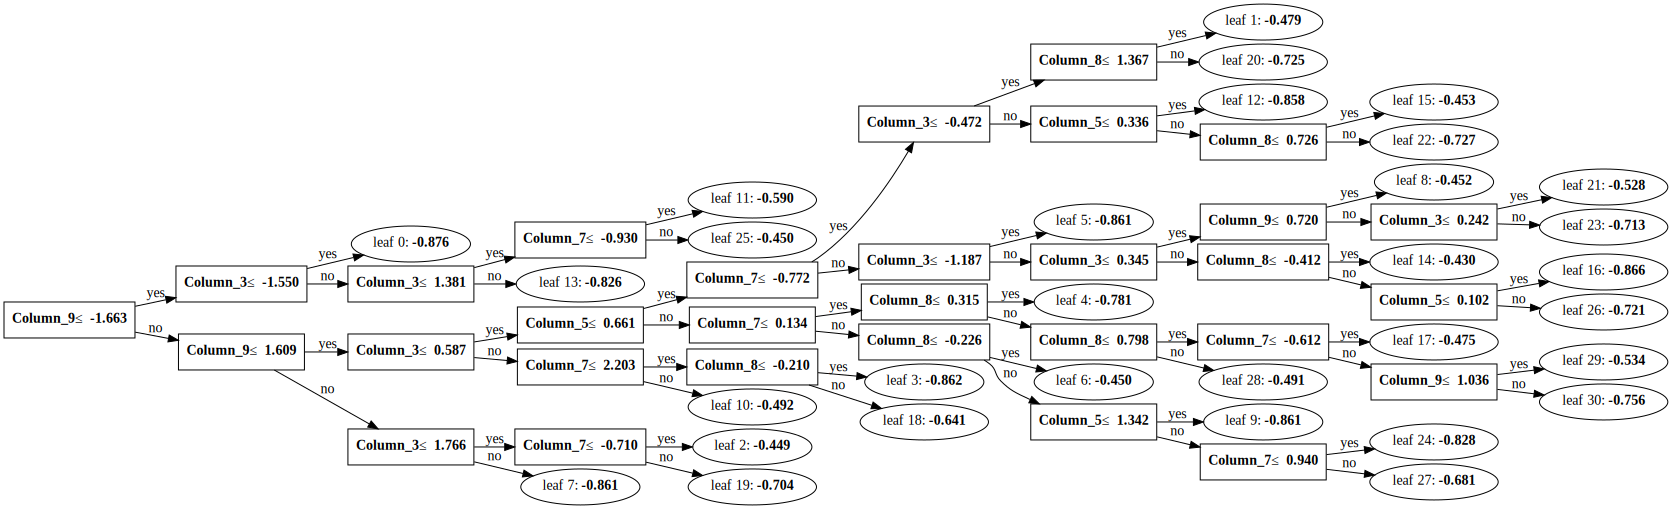

In [1]:
###训练1个lightgbm二分类模型
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=2,
                           n_repeated=0,
                           n_classes=2,
                           weights=[0.7, 0.3],
                           flip_y=0.1,
                           random_state=1024)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1024)

###训练模型
model = lgb.LGBMClassifier(n_estimators=3)
model.fit(X_train, y_train)
lgb.create_tree_digraph(model._Booster, tree_index=0)

In [2]:
import pandas as pd
pd.set_option('display.float_format',lambda x : '%.9f' % x)
###使用模型对测试数据集进行预测
test_pred = model.predict_proba(X_test)[:, 1]
test_pred = pd.DataFrame(test_pred,columns=['python_pred_res'])
test_pred.reset_index(inplace=True)
test_pred.rename(columns={'index':'key'}, inplace=True)
print(test_pred)

       key  python_pred_res
0        0      0.498270894
1        1      0.252486161
2        2      0.252486161
3        3      0.498974049
4        4      0.252486161
...    ...              ...
2495  2495      0.252486161
2496  2496      0.252486161
2497  2497      0.251814023
2498  2498      0.252486161
2499  2499      0.498974049

[2500 rows x 2 columns]


In [3]:
from treemodel2sql import Lgb2Sql
###使用treemodel2sql包将模型转换成的sql语句
lgb2sql = Lgb2Sql()
sql_str = lgb2sql.transform(model)
print(sql_str)


        select key,1 / (1 + exp(-((tree_0_score + tree_1_score + tree_2_score)+(-0.0)))) as score
        from (
        select key,
        --tree0
		case when (Column_9 is null and true==true or Column_9<=-1.6632177658322267) then
			case when (Column_3 is null and true==true or Column_3<=-1.5495347315228287) then
				-0.8762269835062461
			else
				case when (Column_3 is null and true==true or Column_3<=1.3809327191663714) then
					case when (Column_7 is null and true==true or Column_7<=-0.9295802204706084) then
						-0.5897045622608377
					else
						-0.45043755217654896
					end
				else
					-0.8259039361137315
				end
			end
		else
			case when (Column_9 is null and true==true or Column_9<=1.6094262296522934) then
				case when (Column_3 is null and true==true or Column_3<=0.5872311864187175) then
					case when (Column_5 is null and true==true or Column_5<=0.6614392939376948) then
						case when (Column_7 is null and true==true or Column_7<=-0.7719746626173067) then
						

In [4]:
###使用模型转换成的sql语句对测试数据集进行预测
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

X_test_df = pd.DataFrame(X_test)
X_test_df.columns = X_test_df.columns.map(lambda x: "Column_"+str(x))
X_test_df.reset_index(inplace=True)
X_test_df.rename(columns={'index':'key'}, inplace=True)
values = X_test_df.values.tolist()
columns = X_test_df.columns.tolist()
spark_df = spark.createDataFrame(values, columns)
spark_df.createOrReplaceTempView('data_table')
sql_pred_pysdf = spark.sql(sql_str)
sql_pred_df = sql_pred_pysdf.toPandas()
sql_pred_df.head(2)


# ###注意如果核验的测试数据集在本地的某个路径下，使用如下方式读取测试数据
# ###注意如果核验的测试数据集在本地的某个路径下，使用如下方式读取测试数据
# ###注意如果核验的测试数据集在本地的某个路径下，使用如下方式读取测试数据
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.getOrCreate()

# spark_df = spark.read.format("csv").option("header", "true").option("inferSchema", "True").load("/Users/ryanzheng/resources/test_data.csv")
# spark_df = spark_df.withColumnRenamed("device_md5", "key")
# spark_df.createOrReplaceTempView('data_table')
# sql_pred_pysdf = spark.sql(sql_str)
# sql_pred_df = sql_pred_pysdf.toPandas()
# sql_pred_df.head(2)

,key,score
0,0.000000000,0.498270894
1,1.000000000,0.252486161


In [5]:
###对比python模型预测出来的结果和sql语句预测出来的结果是否一致
test_pred_sql_pred_df = test_pred.merge(sql_pred_df, on='key')
test_pred_sql_pred_df['diff'] = test_pred_sql_pred_df['python_pred_res'] - test_pred_sql_pred_df['score']
test_pred_sql_pred_df['diff'].describe()

count   2500.000000000
mean       0.000000000
std        0.000000000
min       -0.000000000
25%        0.000000000
50%        0.000000000
75%        0.000000000
max        0.000000000
Name: diff, dtype: float64

In [6]:
###可以看出差异只有小数位级别，说明sql_str这个语句就是1个模型了。可以放到大数据环境中进行分布式执行，能比单机的python预测快好几个量级
print(sql_str)


        select key,1 / (1 + exp(-((tree_0_score + tree_1_score + tree_2_score)+(-0.0)))) as score
        from (
        select key,
        --tree0
		case when (Column_9 is null and true==true or Column_9<=-1.6632177658322267) then
			case when (Column_3 is null and true==true or Column_3<=-1.5495347315228287) then
				-0.8762269835062461
			else
				case when (Column_3 is null and true==true or Column_3<=1.3809327191663714) then
					case when (Column_7 is null and true==true or Column_7<=-0.9295802204706084) then
						-0.5897045622608377
					else
						-0.45043755217654896
					end
				else
					-0.8259039361137315
				end
			end
		else
			case when (Column_9 is null and true==true or Column_9<=1.6094262296522934) then
				case when (Column_3 is null and true==true or Column_3<=0.5872311864187175) then
					case when (Column_5 is null and true==true or Column_5<=0.6614392939376948) then
						case when (Column_7 is null and true==true or Column_7<=-0.7719746626173067) then
						

In [7]:
###将sql保存
lgb2sql.save()